In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# import sys
# sys.path.insert(0, '../')
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"


import numpy as np
import tensorflow as tf

from gantools import data
from gantools import utils
from gantools import plot
from gantools.model import UpscalePatchWGAN
from gantools.gansystem import GANsystem
from gantools.data import fmap
from gantools import evaluation
import functools
import matplotlib.pyplot as plt
from copy import deepcopy

# Parameters

In [3]:
ns = 16 # Resolution of the image
scaling = 64
try_resume = True

# Data handling

Load the data

In [4]:
dataset = data.load.load_maps_dataset(spix=ns, scaling=scaling, augmentation=True, patch=True)

images shape =  (200, 2304, 2560, 3)


In [5]:
# The dataset can return an iterator.
it = dataset.iter(10)
print(next(it).shape)
del it

(10, 16, 16, 12)


In [6]:
# Get all the data
X = dataset.get_all_data().flatten()

Display the histogram of the pixel densities after the forward map

min: 0.0038910505827516317
max: 0.996070921421051


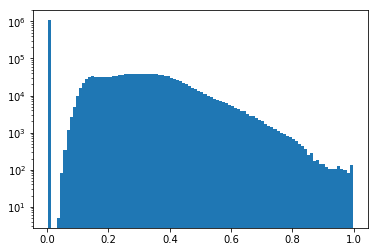

In [7]:
plt.hist(X, 100)
print('min: {}'.format(np.min(X)))
print('max: {}'.format(np.max(X)))
plt.yscale('log')

In [8]:
# to free some memory
del X

Let us plot 16 images

Text(0.5,1,'Real samples')

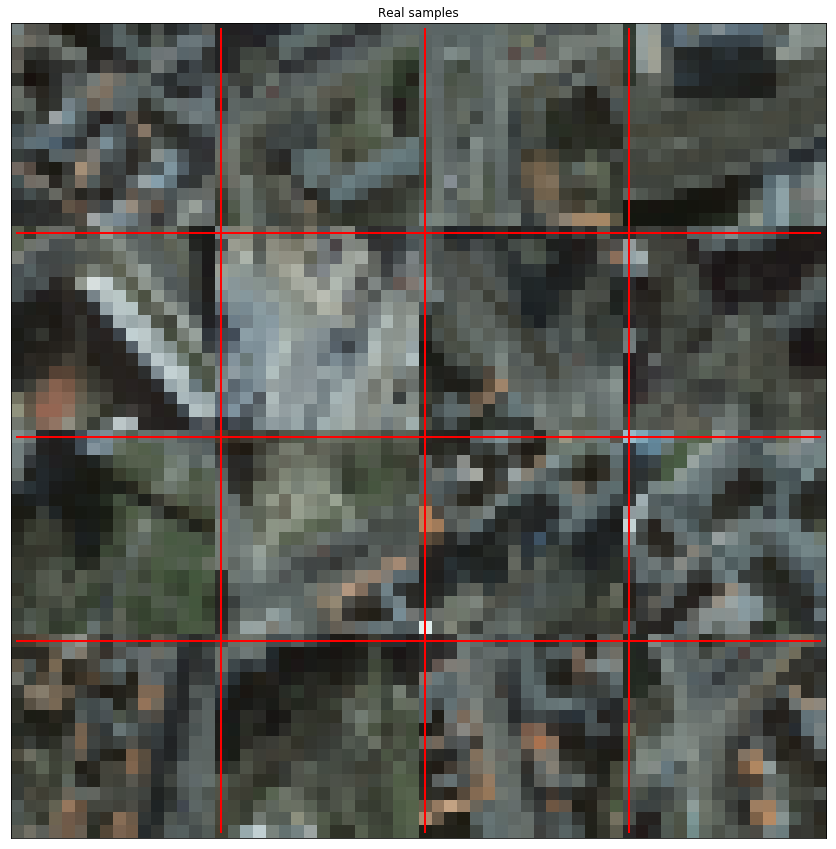

In [9]:
plt.figure(figsize=(15,15))
plot.draw_images(dataset.get_samples(N=16)[:,:,:,:3],nx=4,ny=4);
plt.title("Real samples")

# Define parameters for the WGAN

In [10]:
time_str = 'maps_scaling{}'.format(scaling)
global_path = '../saved_results'

name = 'WGAN{}'.format(ns) + '_' + time_str

## Parameters

In [17]:
bn = True

def non_lin(x):
    return (tf.nn.tanh(x) + 1.0)/2.0

md=16

params_discriminator = dict()
params_discriminator['stride'] = [2, 2, 1, 1, 1]
params_discriminator['nfilter'] = [md, 4*md, 16*md, 16*md, 8]
params_discriminator['shape'] = [[5, 5],[5, 5], [5, 5], [5, 5], [5, 5]]
params_discriminator['batch_norm'] = [bn, bn, bn, bn, bn]
params_discriminator['full'] = [512, 256]
params_discriminator['minibatch_reg'] = True
params_discriminator['summary'] = True
params_discriminator['data_size'] = 2
params_discriminator['inception'] = True
params_discriminator['spectral_norm'] = True

params_generator = dict()
params_generator['stride'] = [1, 1, 1, 1, 1, 1]
params_generator['latent_dim'] = 256
params_generator['nfilter'] = [md, md, md, md,md, 3]
params_generator['shape'] = [[5, 5], [5, 5],[5, 5], [5, 5],[5, 5],[5, 5]]
params_generator['batch_norm'] = [False, False, False, False, False]
params_generator['full'] = [ns*ns*2]
params_generator['summary'] = True
params_generator['non_lin'] = non_lin
params_generator['data_size'] = 2
params_generator['borders'] = dict()
params_generator['borders']['nfilter'] = [12, 4]
params_generator['borders']['batch_norm'] = [False, False]
params_generator['borders']['shape'] = [[5, 5], [3, 3]]
params_generator['borders']['stride'] = [2, 1]
params_generator['borders']['data_size'] = 2
params_generator['borders']['width_full'] = None
params_generator['inception'] = True
params_generator['spectral_norm'] = True

params_optimization = dict()
params_optimization['batch_size'] = 16
params_optimization['epoch'] = 10000
params_optimization['n_critic'] = 2
params_optimization['generator'] = dict()
params_optimization['generator']['optimizer'] = 'adam'
params_optimization['generator']['kwargs'] = {'beta1':0, 'beta2':0.9}
params_optimization['generator']['learning_rate'] = 0.0004
params_optimization['discriminator'] = dict()
params_optimization['discriminator']['optimizer'] = 'adam'
params_optimization['discriminator']['kwargs'] = {'beta1':0, 'beta2':0.9}
params_optimization['discriminator']['learning_rate'] = 0.0001




# all parameters
params = dict()
params['net'] = dict() # All the parameters for the model
params['net']['generator'] = params_generator
params['net']['discriminator'] = params_discriminator
params['net']['prior_distribution'] = 'gaussian'
params['net']['shape'] = [ns, ns, 12] # Shape of the image
params['net']['gamma_gp'] = 10 # Gradient penalty
params['net']['upsampling'] = None 

params['optimization'] = params_optimization
params['summary_every'] = 100 # Tensorboard summaries every ** iterations
params['print_every'] = 50 # Console summaries every ** iterations
params['save_every'] = 1000 # Save the model every ** iterations
params['summary_dir'] = os.path.join(global_path, name +'_summary/')
params['save_dir'] = os.path.join(global_path, name + '_checkpoints/')
params['Nstats'] = 200

resume, params = utils.test_resume(try_resume, params)


# Build the model

In [18]:
wgan = GANsystem(UpscalePatchWGAN, params)

Border block

--------------------------------------------------
     BORDER:  The input is of size (?, 16, 16, 9)
     BORDER: 0 Conv layer with 12 channels
         BORDER:  Size of the conv variables: (?, 8, 8, 12)
     BORDER: 1 Conv layer with 4 channels
         BORDER:  Size of the conv variables: (?, 8, 8, 4)
     BORDER:  Size of the conv variables: (?, 256)
--------------------------------------------------

Generator 
--------------------------------------------------
     The input is of size (?, 256)
     Contenate with latent variables to (?, 512)
     0 Full layer with 512 outputs
         Size of the variables: (?, 512)
     Reshape to (?, 16, 16, 2)
     0 Inception conv(1x1,3x3,5x5) layer with 16 channels
         Non linearity applied
         Size of the variables: (?, 16, 16, 48)
     1 Inception conv(1x1,3x3,5x5) layer with 16 channels
         Non linearity applied
         Size of the variables: (?, 16, 16, 48)
     2 Inception conv(1x1,3x3,5x5) layer with 16 ch

# Train the model

In [19]:
wgan.train(dataset, resume=resume)

Compute real statistics: descriptives/mean_l2
Compute real statistics: descriptives/var_l2
Compute real statistics: descriptives/min_l2
Compute real statistics: descriptives/max_l2
Compute real statistics: descriptives/kurtosis_l2
Compute real statistics: descriptives/skewness_l2
Compute real statistics: descriptives/median_l2
Erase recursively directory: ../saved_results/WGAN16_maps_scaling64_summary/
Erase recursively directory: ../saved_results/WGAN16_maps_scaling64_checkpoints/
Start training
 * Epoch: [ 0] [  50/  50] Counter:50	( 0.2 min	59.910 examples/sec	0.27 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.25673805
   Gen batch loss:1.61878514	Gen epoch loss:1.30239625
 * Epoch: [ 1] [  50/  50] Counter:100	( 0.3 min	122.751 examples/sec	0.13 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00796227
   Gen batch loss:3.08280015	Gen epoch loss:2.44928234
 * Epoch: [ 2] [  50/  50] Counter:150	( 0.6 min	57.525 examples/sec	0.28 sec/batch)
   Disc batch loss:

 * Epoch: [39] [  50/  50] Counter:2000	( 4.8 min	119.340 examples/sec	0.13 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.02452637
   Gen batch loss:1.52114010	Gen epoch loss:3.81562808
Model saved!
 * Epoch: [40] [  50/  50] Counter:2050	( 4.9 min	99.314 examples/sec	0.16 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:2.58938837	Gen epoch loss:3.68211071
 * Epoch: [41] [  50/  50] Counter:2100	( 5.0 min	118.210 examples/sec	0.14 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.03798527
   Gen batch loss:5.21052361	Gen epoch loss:4.69152258
 * Epoch: [42] [  50/  50] Counter:2150	( 5.1 min	118.766 examples/sec	0.13 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.13530268
   Gen batch loss:3.52111292	Gen epoch loss:3.88711926
 * Epoch: [43] [  50/  50] Counter:2200	( 5.2 min	119.680 examples/sec	0.13 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.06959095
   Gen batch loss:1.93503952	Gen epoch loss:3.47

 * Epoch: [80] [  50/  50] Counter:4050	( 9.4 min	101.462 examples/sec	0.16 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.04178226
   Gen batch loss:2.42089033	Gen epoch loss:3.54228608
 * Epoch: [81] [  50/  50] Counter:4100	( 9.5 min	120.452 examples/sec	0.13 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.08779167
   Gen batch loss:3.97450590	Gen epoch loss:4.36446855
 * Epoch: [82] [  50/  50] Counter:4150	( 9.7 min	117.376 examples/sec	0.14 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.05258085
   Gen batch loss:6.69004107	Gen epoch loss:3.81353206
 * Epoch: [83] [  50/  50] Counter:4200	( 9.8 min	119.520 examples/sec	0.13 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.07886014
   Gen batch loss:3.44495749	Gen epoch loss:3.97848184
 * Epoch: [84] [  50/  50] Counter:4250	( 9.9 min	117.951 examples/sec	0.14 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.06368626
   Gen batch loss:5.54663372	Gen epoch loss:4.08169987
 * Ep

 * Epoch: [121] [  50/  50] Counter:6100	(14.0 min	121.512 examples/sec	0.13 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00100134
   Gen batch loss:8.28997231	Gen epoch loss:4.22705314
 * Epoch: [122] [  50/  50] Counter:6150	(14.1 min	119.132 examples/sec	0.13 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00750067
   Gen batch loss:4.38440895	Gen epoch loss:3.97926988
 * Epoch: [123] [  50/  50] Counter:6200	(14.2 min	121.939 examples/sec	0.13 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.06478668
   Gen batch loss:8.36469460	Gen epoch loss:4.77752107
 * Epoch: [124] [  50/  50] Counter:6250	(14.4 min	119.169 examples/sec	0.13 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.13356881
   Gen batch loss:1.62892020	Gen epoch loss:4.56597544
 * Epoch: [125] [  50/  50] Counter:6300	(14.5 min	121.910 examples/sec	0.13 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00688886
   Gen batch loss:3.56214952	Gen epoch loss:4.65092222


 * Epoch: [162] [  50/  50] Counter:8150	(18.6 min	119.082 examples/sec	0.13 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.01899489
   Gen batch loss:3.84600377	Gen epoch loss:4.47302580
 * Epoch: [163] [  50/  50] Counter:8200	(18.7 min	122.188 examples/sec	0.13 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.03650490
   Gen batch loss:2.75163031	Gen epoch loss:3.94803002
 * Epoch: [164] [  50/  50] Counter:8250	(18.8 min	119.209 examples/sec	0.13 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.01566418
   Gen batch loss:7.84803486	Gen epoch loss:4.45929058
 * Epoch: [165] [  50/  50] Counter:8300	(18.9 min	121.153 examples/sec	0.13 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.01604490
   Gen batch loss:5.56623411	Gen epoch loss:4.33006678
 * Epoch: [166] [  50/  50] Counter:8350	(19.1 min	118.961 examples/sec	0.13 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.01292105
   Gen batch loss:1.96463919	Gen epoch loss:4.72016128


 * Epoch: [203] [  50/  50] Counter:10200	(23.2 min	121.717 examples/sec	0.13 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.02056486
   Gen batch loss:6.54826260	Gen epoch loss:4.39702414
 * Epoch: [204] [  50/  50] Counter:10250	(23.3 min	119.366 examples/sec	0.13 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.04488413
   Gen batch loss:1.27893329	Gen epoch loss:4.41829609
 * Epoch: [205] [  50/  50] Counter:10300	(23.4 min	121.927 examples/sec	0.13 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.05131930
   Gen batch loss:5.66370201	Gen epoch loss:4.33587556
 * Epoch: [206] [  50/  50] Counter:10350	(23.5 min	118.827 examples/sec	0.13 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00243090
   Gen batch loss:7.46638489	Gen epoch loss:4.20968527
 * Epoch: [207] [  50/  50] Counter:10400	(23.6 min	121.579 examples/sec	0.13 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.06050557
   Gen batch loss:1.57238841	Gen epoch loss:4.5280

 * Epoch: [244] [  50/  50] Counter:12250	(27.8 min	119.001 examples/sec	0.13 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00332627
   Gen batch loss:2.81112862	Gen epoch loss:4.17274186
 * Epoch: [245] [  50/  50] Counter:12300	(27.9 min	121.771 examples/sec	0.13 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.03389509
   Gen batch loss:3.53507662	Gen epoch loss:3.89498302
 * Epoch: [246] [  50/  50] Counter:12350	(28.0 min	118.522 examples/sec	0.13 sec/batch)
   Disc batch loss:0.03525341	Disc epoch loss:0.04974435
   Gen batch loss:0.96474659	Gen epoch loss:3.88723145
 * Epoch: [247] [  50/  50] Counter:12400	(28.1 min	122.313 examples/sec	0.13 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.10157414
   Gen batch loss:3.53182077	Gen epoch loss:3.67594836
 * Epoch: [248] [  50/  50] Counter:12450	(28.2 min	119.653 examples/sec	0.13 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.03612585
   Gen batch loss:1.48682702	Gen epoch loss:4.2234

 * Epoch: [285] [  50/  50] Counter:14300	(32.4 min	121.415 examples/sec	0.13 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.01694083
   Gen batch loss:3.04804707	Gen epoch loss:4.15591596
 * Epoch: [286] [  50/  50] Counter:14350	(32.5 min	118.344 examples/sec	0.14 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.01903903
   Gen batch loss:5.81630611	Gen epoch loss:4.01370288
 * Epoch: [287] [  50/  50] Counter:14400	(32.6 min	120.781 examples/sec	0.13 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.09345926
   Gen batch loss:3.60649204	Gen epoch loss:3.95724508
 * Epoch: [288] [  50/  50] Counter:14450	(32.7 min	119.039 examples/sec	0.13 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.06858923
   Gen batch loss:5.73674202	Gen epoch loss:4.48811318
 * Epoch: [289] [  50/  50] Counter:14500	(32.8 min	121.551 examples/sec	0.13 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.03160169
   Gen batch loss:3.96874404	Gen epoch loss:4.5518

 * Epoch: [326] [  50/  50] Counter:16350	(37.0 min	118.373 examples/sec	0.14 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:2.12287807	Gen epoch loss:4.39734957
 * Epoch: [327] [  50/  50] Counter:16400	(37.1 min	121.251 examples/sec	0.13 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.04740464
   Gen batch loss:3.25956917	Gen epoch loss:4.24583229
 * Epoch: [328] [  50/  50] Counter:16450	(37.2 min	119.680 examples/sec	0.13 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00509382
   Gen batch loss:3.93963051	Gen epoch loss:4.27273686
 * Epoch: [329] [  50/  50] Counter:16500	(37.3 min	120.685 examples/sec	0.13 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.05168354
   Gen batch loss:3.94164753	Gen epoch loss:3.82434300
 * Epoch: [330] [  50/  50] Counter:16550	(37.4 min	119.591 examples/sec	0.13 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.02186957
   Gen batch loss:4.96320868	Gen epoch loss:4.0900

 * Epoch: [367] [  50/  50] Counter:18400	(41.5 min	121.370 examples/sec	0.13 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00447262
   Gen batch loss:1.67884219	Gen epoch loss:4.00182186
 * Epoch: [368] [  50/  50] Counter:18450	(41.7 min	119.238 examples/sec	0.13 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.02778693
   Gen batch loss:5.98928261	Gen epoch loss:3.98584391
 * Epoch: [369] [  50/  50] Counter:18500	(41.8 min	121.181 examples/sec	0.13 sec/batch)
   Disc batch loss:0.35962766	Disc epoch loss:0.07637216
   Gen batch loss:0.64037234	Gen epoch loss:3.49547028
 * Epoch: [370] [  50/  50] Counter:18550	(41.9 min	119.876 examples/sec	0.13 sec/batch)
   Disc batch loss:0.00467700	Disc epoch loss:0.02061548
   Gen batch loss:0.99532300	Gen epoch loss:4.35108113
 * Epoch: [371] [  50/  50] Counter:18600	(42.0 min	121.727 examples/sec	0.13 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.08264565
   Gen batch loss:2.68764591	Gen epoch loss:4.5686

 * Epoch: [408] [  50/  50] Counter:20450	(46.1 min	119.001 examples/sec	0.13 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00590061
   Gen batch loss:4.86280155	Gen epoch loss:3.75077661
 * Epoch: [409] [  50/  50] Counter:20500	(46.2 min	122.011 examples/sec	0.13 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.03040208
   Gen batch loss:4.64277744	Gen epoch loss:4.00164707
 * Epoch: [410] [  50/  50] Counter:20550	(46.3 min	119.603 examples/sec	0.13 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.09158229
   Gen batch loss:3.13998890	Gen epoch loss:3.67634068
 * Epoch: [411] [  50/  50] Counter:20600	(46.5 min	121.234 examples/sec	0.13 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.01320637
   Gen batch loss:5.43800497	Gen epoch loss:3.58861388
 * Epoch: [412] [  50/  50] Counter:20650	(46.6 min	119.271 examples/sec	0.13 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.03019270
   Gen batch loss:2.07760692	Gen epoch loss:3.8390

 * Epoch: [449] [  50/  50] Counter:22500	(50.7 min	121.083 examples/sec	0.13 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00412915
   Gen batch loss:2.98964810	Gen epoch loss:4.86321575
 * Epoch: [450] [  50/  50] Counter:22550	(50.8 min	119.769 examples/sec	0.13 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.04456004
   Gen batch loss:2.59453893	Gen epoch loss:4.43981103
 * Epoch: [451] [  50/  50] Counter:22600	(50.9 min	121.559 examples/sec	0.13 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:6.47986174	Gen epoch loss:4.61167757
 * Epoch: [452] [  50/  50] Counter:22650	(51.0 min	118.669 examples/sec	0.13 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.01987347
   Gen batch loss:6.70900822	Gen epoch loss:4.16776993
 * Epoch: [453] [  50/  50] Counter:22700	(51.1 min	121.887 examples/sec	0.13 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00168722
   Gen batch loss:2.73110151	Gen epoch loss:4.4143

 * Epoch: [490] [  50/  50] Counter:24550	(55.3 min	117.761 examples/sec	0.14 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.08370629
   Gen batch loss:2.61166811	Gen epoch loss:4.56914448
 * Epoch: [491] [  50/  50] Counter:24600	(55.4 min	121.456 examples/sec	0.13 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.02576928
   Gen batch loss:3.35964894	Gen epoch loss:4.19609780
 * Epoch: [492] [  50/  50] Counter:24650	(55.5 min	119.854 examples/sec	0.13 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00598317
   Gen batch loss:7.23644638	Gen epoch loss:3.64680812
 * Epoch: [493] [  50/  50] Counter:24700	(55.6 min	121.220 examples/sec	0.13 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.02382498
   Gen batch loss:6.59397888	Gen epoch loss:4.04091165
 * Epoch: [494] [  50/  50] Counter:24750	(55.7 min	118.681 examples/sec	0.13 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:4.86293936	Gen epoch loss:3.9526

 * Epoch: [531] [  50/  50] Counter:26600	(59.9 min	121.844 examples/sec	0.13 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:3.10668993	Gen epoch loss:4.34942204
 * Epoch: [532] [  50/  50] Counter:26650	(60.0 min	119.423 examples/sec	0.13 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00720323
   Gen batch loss:3.93048668	Gen epoch loss:3.81131395
 * Epoch: [533] [  50/  50] Counter:26700	(60.1 min	120.896 examples/sec	0.13 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:2.74811983	Gen epoch loss:4.56271377
 * Epoch: [534] [  50/  50] Counter:26750	(60.2 min	118.812 examples/sec	0.13 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.08634869
   Gen batch loss:10.75252914	Gen epoch loss:4.49053527
 * Epoch: [535] [  50/  50] Counter:26800	(60.3 min	121.740 examples/sec	0.13 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.09868759
   Gen batch loss:3.36304450	Gen epoch loss:4.470

 * Epoch: [572] [  50/  50] Counter:28650	(64.4 min	119.400 examples/sec	0.13 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.15507362
   Gen batch loss:5.38495874	Gen epoch loss:4.36789905
 * Epoch: [573] [  50/  50] Counter:28700	(64.6 min	122.326 examples/sec	0.13 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.05411916
   Gen batch loss:3.42442894	Gen epoch loss:4.48476074
 * Epoch: [574] [  50/  50] Counter:28750	(64.7 min	119.068 examples/sec	0.13 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.03796329
   Gen batch loss:6.12984943	Gen epoch loss:5.08673586
 * Epoch: [575] [  50/  50] Counter:28800	(64.8 min	121.661 examples/sec	0.13 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:5.47891235	Gen epoch loss:4.87005087
 * Epoch: [576] [  50/  50] Counter:28850	(64.9 min	118.899 examples/sec	0.13 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:6.62437534	Gen epoch loss:4.4800

 * Epoch: [613] [  50/  50] Counter:30700	(69.0 min	121.235 examples/sec	0.13 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00038106
   Gen batch loss:5.37523746	Gen epoch loss:4.99874960
 * Epoch: [614] [  50/  50] Counter:30750	(69.1 min	118.964 examples/sec	0.13 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.01430264
   Gen batch loss:1.95579314	Gen epoch loss:4.29804988
 * Epoch: [615] [  50/  50] Counter:30800	(69.2 min	121.875 examples/sec	0.13 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.05991421
   Gen batch loss:3.68770313	Gen epoch loss:3.86318724
 * Epoch: [616] [  50/  50] Counter:30850	(69.4 min	119.684 examples/sec	0.13 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.03609782
   Gen batch loss:5.05184317	Gen epoch loss:4.31596517
 * Epoch: [617] [  50/  50] Counter:30900	(69.5 min	121.811 examples/sec	0.13 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.02045377
   Gen batch loss:3.74652958	Gen epoch loss:4.5496

 * Epoch: [654] [  50/  50] Counter:32750	(73.6 min	119.189 examples/sec	0.13 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.06378518
   Gen batch loss:8.47794437	Gen epoch loss:4.67813482
 * Epoch: [655] [  50/  50] Counter:32800	(73.7 min	121.875 examples/sec	0.13 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:2.19156861	Gen epoch loss:4.65799468
 * Epoch: [656] [  50/  50] Counter:32850	(73.8 min	121.153 examples/sec	0.13 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.01796331
   Gen batch loss:5.18333530	Gen epoch loss:4.10835615
 * Epoch: [657] [  50/  50] Counter:32900	(73.9 min	121.930 examples/sec	0.13 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.05973252
   Gen batch loss:1.53470671	Gen epoch loss:4.51538223
 * Epoch: [658] [  50/  50] Counter:32950	(74.0 min	119.303 examples/sec	0.13 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:1.56755745	Gen epoch loss:4.0733

 * Epoch: [695] [  50/  50] Counter:34800	(78.2 min	120.753 examples/sec	0.13 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.03455570
   Gen batch loss:7.90019846	Gen epoch loss:4.69636466
 * Epoch: [696] [  50/  50] Counter:34850	(78.3 min	119.624 examples/sec	0.13 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.03639626
   Gen batch loss:2.50591040	Gen epoch loss:4.48811255
 * Epoch: [697] [  50/  50] Counter:34900	(78.4 min	120.968 examples/sec	0.13 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:1.26251280	Gen epoch loss:4.36641726
 * Epoch: [698] [  50/  50] Counter:34950	(78.5 min	119.242 examples/sec	0.13 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00329854
   Gen batch loss:4.44640446	Gen epoch loss:4.79460870
 * Epoch: [699] [  50/  50] Counter:35000	(78.6 min	120.054 examples/sec	0.13 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.11361737
   Gen batch loss:8.17196178	Gen epoch loss:4.6619

 * Epoch: [736] [  50/  50] Counter:36850	(82.8 min	118.274 examples/sec	0.14 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.04408244
   Gen batch loss:2.05195665	Gen epoch loss:5.21067868
 * Epoch: [737] [  50/  50] Counter:36900	(82.9 min	120.657 examples/sec	0.13 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:1.60026622	Gen epoch loss:5.29617215
 * Epoch: [738] [  50/  50] Counter:36950	(83.0 min	119.169 examples/sec	0.13 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00336799
   Gen batch loss:4.62283611	Gen epoch loss:4.73643078
 * Epoch: [739] [  50/  50] Counter:37000	(83.1 min	121.923 examples/sec	0.13 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:3.05519724	Gen epoch loss:4.22905999
Model saved!
 * Epoch: [740] [  50/  50] Counter:37050	(83.2 min	101.474 examples/sec	0.16 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:4.33591223	Gen epoc

 * Epoch: [777] [  50/  50] Counter:38900	(87.4 min	122.055 examples/sec	0.13 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.02159177
   Gen batch loss:8.66837883	Gen epoch loss:4.86673039
 * Epoch: [778] [  50/  50] Counter:38950	(87.5 min	118.995 examples/sec	0.13 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:3.19298458	Gen epoch loss:4.64677378
 * Epoch: [779] [  50/  50] Counter:39000	(87.6 min	120.596 examples/sec	0.13 sec/batch)
   Disc batch loss:0.35451782	Disc epoch loss:0.01927269
   Gen batch loss:0.64548218	Gen epoch loss:4.90432258
Model saved!
 * Epoch: [780] [  50/  50] Counter:39050	(87.7 min	98.946 examples/sec	0.16 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.02883942
   Gen batch loss:4.26326704	Gen epoch loss:4.16381304
 * Epoch: [781] [  50/  50] Counter:39100	(87.8 min	121.828 examples/sec	0.13 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.01951165
   Gen batch loss:4.81777763	Gen epoch

 * Epoch: [818] [  50/  50] Counter:40950	(91.9 min	119.152 examples/sec	0.13 sec/batch)
   Disc batch loss:2.24121404	Disc epoch loss:0.10435872
   Gen batch loss:9.97865200	Gen epoch loss:5.28923974
 * Epoch: [819] [  50/  50] Counter:41000	(92.1 min	121.357 examples/sec	0.13 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.01436367
   Gen batch loss:2.49979258	Gen epoch loss:4.58265289
Model saved!
 * Epoch: [820] [  50/  50] Counter:41050	(92.2 min	101.383 examples/sec	0.16 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.05421319
   Gen batch loss:7.39772463	Gen epoch loss:4.11476918
 * Epoch: [821] [  50/  50] Counter:41100	(92.3 min	121.591 examples/sec	0.13 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.02277126
   Gen batch loss:3.52411461	Gen epoch loss:4.25679876
 * Epoch: [822] [  50/  50] Counter:41150	(92.4 min	118.557 examples/sec	0.13 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.05568869
   Gen batch loss:3.02415681	Gen epoc

 * Epoch: [859] [  50/  50] Counter:43000	(96.5 min	122.362 examples/sec	0.13 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.14849402
   Gen batch loss:11.40875340	Gen epoch loss:5.38642249
Model saved!
 * Epoch: [860] [  50/  50] Counter:43050	(96.7 min	101.936 examples/sec	0.16 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:3.05868769	Gen epoch loss:5.01865555
 * Epoch: [861] [  50/  50] Counter:43100	(96.8 min	121.834 examples/sec	0.13 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00957624
   Gen batch loss:6.80072021	Gen epoch loss:4.65407825
 * Epoch: [862] [  50/  50] Counter:43150	(96.9 min	118.931 examples/sec	0.13 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.01313325
   Gen batch loss:7.19359732	Gen epoch loss:5.52875175
 * Epoch: [863] [  50/  50] Counter:43200	(97.0 min	121.512 examples/sec	0.13 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.04238827
   Gen batch loss:7.86682320	Gen epo

Model saved!
 * Epoch: [900] [  50/  50] Counter:45050	(101.1 min	101.943 examples/sec	0.16 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00530777
   Gen batch loss:1.44474483	Gen epoch loss:4.23326859
 * Epoch: [901] [  50/  50] Counter:45100	(101.2 min	120.473 examples/sec	0.13 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.02036484
   Gen batch loss:7.81277418	Gen epoch loss:4.42036609
 * Epoch: [902] [  50/  50] Counter:45150	(101.4 min	118.317 examples/sec	0.14 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.01183212
   Gen batch loss:3.65573502	Gen epoch loss:4.34391743
 * Epoch: [903] [  50/  50] Counter:45200	(101.5 min	122.568 examples/sec	0.13 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00676882
   Gen batch loss:4.40600777	Gen epoch loss:4.41729832
 * Epoch: [904] [  50/  50] Counter:45250	(101.6 min	119.673 examples/sec	0.13 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.02578585
   Gen batch loss:3.00649405	Gen

 * Epoch: [941] [  50/  50] Counter:47100	(105.7 min	121.920 examples/sec	0.13 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.05318901
   Gen batch loss:7.35608482	Gen epoch loss:5.31678491
 * Epoch: [942] [  50/  50] Counter:47150	(105.8 min	119.684 examples/sec	0.13 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:6.71298456	Gen epoch loss:4.81708992
 * Epoch: [943] [  50/  50] Counter:47200	(105.9 min	122.557 examples/sec	0.13 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.06557286
   Gen batch loss:8.37412167	Gen epoch loss:4.87927444
 * Epoch: [944] [  50/  50] Counter:47250	(106.0 min	119.078 examples/sec	0.13 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.04447095
   Gen batch loss:7.04638052	Gen epoch loss:4.56623582
 * Epoch: [945] [  50/  50] Counter:47300	(106.2 min	120.806 examples/sec	0.13 sec/batch)
   Disc batch loss:0.09394217	Disc epoch loss:0.01719975
   Gen batch loss:0.90605783	Gen epoch loss:4

 * Epoch: [982] [  50/  50] Counter:49150	(110.3 min	118.047 examples/sec	0.14 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.04316853
   Gen batch loss:4.68354034	Gen epoch loss:4.76404608
 * Epoch: [983] [  50/  50] Counter:49200	(110.4 min	122.498 examples/sec	0.13 sec/batch)
   Disc batch loss:0.41456550	Disc epoch loss:0.02481160
   Gen batch loss:0.58543450	Gen epoch loss:3.92720250
 * Epoch: [984] [  50/  50] Counter:49250	(110.5 min	119.177 examples/sec	0.13 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00169084
   Gen batch loss:7.27206802	Gen epoch loss:4.72066934
 * Epoch: [985] [  50/  50] Counter:49300	(110.6 min	123.185 examples/sec	0.13 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00114568
   Gen batch loss:2.81646013	Gen epoch loss:4.30363776
 * Epoch: [986] [  50/  50] Counter:49350	(110.7 min	119.416 examples/sec	0.13 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:2.70256758	Gen epoch loss:4

 * Epoch: [1023] [  50/  50] Counter:51200	(114.9 min	122.242 examples/sec	0.13 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:7.54456139	Gen epoch loss:4.90659594
 * Epoch: [1024] [  50/  50] Counter:51250	(115.0 min	119.807 examples/sec	0.13 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.05427756
   Gen batch loss:9.00662518	Gen epoch loss:4.81440633
 * Epoch: [1025] [  50/  50] Counter:51300	(115.1 min	122.093 examples/sec	0.13 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00757386
   Gen batch loss:8.17545414	Gen epoch loss:4.63057123
 * Epoch: [1026] [  50/  50] Counter:51350	(115.2 min	118.873 examples/sec	0.13 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.07490157
   Gen batch loss:3.24636889	Gen epoch loss:4.47501913
 * Epoch: [1027] [  50/  50] Counter:51400	(115.3 min	121.733 examples/sec	0.13 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.02470495
   Gen batch loss:5.93577385	Gen epoch l

 * Epoch: [1064] [  50/  50] Counter:53250	(119.5 min	117.042 examples/sec	0.14 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.01605312
   Gen batch loss:5.25465107	Gen epoch loss:4.84517418
 * Epoch: [1065] [  50/  50] Counter:53300	(119.6 min	120.092 examples/sec	0.13 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.06212658
   Gen batch loss:3.21536088	Gen epoch loss:4.52731938
 * Epoch: [1066] [  50/  50] Counter:53350	(119.7 min	117.353 examples/sec	0.14 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:6.35440683	Gen epoch loss:3.55551738
 * Epoch: [1067] [  50/  50] Counter:53400	(119.8 min	120.260 examples/sec	0.13 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.03793471
   Gen batch loss:2.58522940	Gen epoch loss:3.92810432
 * Epoch: [1068] [  50/  50] Counter:53450	(120.0 min	117.585 examples/sec	0.14 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.09277250
   Gen batch loss:5.91412926	Gen epoch l

 * Epoch: [1105] [  50/  50] Counter:55300	(124.2 min	121.050 examples/sec	0.13 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00027306
   Gen batch loss:4.50740433	Gen epoch loss:4.64806645
 * Epoch: [1106] [  50/  50] Counter:55350	(124.3 min	118.883 examples/sec	0.13 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00889375
   Gen batch loss:1.00940442	Gen epoch loss:4.06662965
 * Epoch: [1107] [  50/  50] Counter:55400	(124.4 min	119.803 examples/sec	0.13 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.03140671
   Gen batch loss:3.39760828	Gen epoch loss:4.21749940
 * Epoch: [1108] [  50/  50] Counter:55450	(124.5 min	117.323 examples/sec	0.14 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.05346301
   Gen batch loss:3.13852096	Gen epoch loss:4.81376243
 * Epoch: [1109] [  50/  50] Counter:55500	(124.6 min	120.091 examples/sec	0.13 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.01543747
   Gen batch loss:5.34503746	Gen epoch l

 * Epoch: [1146] [  50/  50] Counter:57350	(128.8 min	116.750 examples/sec	0.14 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.02762246
   Gen batch loss:7.82475567	Gen epoch loss:4.73783926
 * Epoch: [1147] [  50/  50] Counter:57400	(128.9 min	118.828 examples/sec	0.13 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.01418513
   Gen batch loss:2.11558580	Gen epoch loss:4.12222280
 * Epoch: [1148] [  50/  50] Counter:57450	(129.1 min	116.178 examples/sec	0.14 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:6.88177204	Gen epoch loss:4.79740140
 * Epoch: [1149] [  50/  50] Counter:57500	(129.2 min	119.398 examples/sec	0.13 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.04719553
   Gen batch loss:6.31418705	Gen epoch loss:4.29654304
 * Epoch: [1150] [  50/  50] Counter:57550	(129.3 min	118.299 examples/sec	0.14 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.02897098
   Gen batch loss:4.10293245	Gen epoch l

 * Epoch: [1187] [  50/  50] Counter:59400	(133.5 min	119.609 examples/sec	0.13 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.05578763
   Gen batch loss:7.40843725	Gen epoch loss:5.16758718
 * Epoch: [1188] [  50/  50] Counter:59450	(133.6 min	118.072 examples/sec	0.14 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.03267069
   Gen batch loss:3.13820767	Gen epoch loss:5.39858539
 * Epoch: [1189] [  50/  50] Counter:59500	(133.7 min	118.804 examples/sec	0.13 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.01024745
   Gen batch loss:6.44605732	Gen epoch loss:4.33173949
 * Epoch: [1190] [  50/  50] Counter:59550	(133.8 min	115.094 examples/sec	0.14 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.01784291
   Gen batch loss:8.77014542	Gen epoch loss:4.77641423
 * Epoch: [1191] [  50/  50] Counter:59600	(133.9 min	120.110 examples/sec	0.13 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.03908351
   Gen batch loss:3.88013649	Gen epoch l

 * Epoch: [1228] [  50/  50] Counter:61450	(138.2 min	115.982 examples/sec	0.14 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.01770589
   Gen batch loss:2.42406225	Gen epoch loss:4.33324070
 * Epoch: [1229] [  50/  50] Counter:61500	(138.3 min	119.414 examples/sec	0.13 sec/batch)
   Disc batch loss:0.70456338	Disc epoch loss:0.04377183
   Gen batch loss:0.29543662	Gen epoch loss:4.74697218
 * Epoch: [1230] [  50/  50] Counter:61550	(138.4 min	117.756 examples/sec	0.14 sec/batch)
   Disc batch loss:0.88611823	Disc epoch loss:0.09004637
   Gen batch loss:8.99630737	Gen epoch loss:4.50090071
 * Epoch: [1231] [  50/  50] Counter:61600	(138.5 min	118.627 examples/sec	0.13 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.02358613
   Gen batch loss:9.50573063	Gen epoch loss:5.21758425
 * Epoch: [1232] [  50/  50] Counter:61650	(138.6 min	116.192 examples/sec	0.14 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.01823874
   Gen batch loss:6.13087273	Gen epoch l

 * Epoch: [1269] [  50/  50] Counter:63500	(142.8 min	118.272 examples/sec	0.14 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.01727147
   Gen batch loss:6.95125961	Gen epoch loss:4.21350431
 * Epoch: [1270] [  50/  50] Counter:63550	(143.0 min	116.477 examples/sec	0.14 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.02223582
   Gen batch loss:7.23776531	Gen epoch loss:4.58767786
 * Epoch: [1271] [  50/  50] Counter:63600	(143.1 min	118.870 examples/sec	0.13 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00312541
   Gen batch loss:6.21168232	Gen epoch loss:5.28132871
 * Epoch: [1272] [  50/  50] Counter:63650	(143.2 min	116.586 examples/sec	0.14 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.04925418
   Gen batch loss:6.74926233	Gen epoch loss:4.82589085
 * Epoch: [1273] [  50/  50] Counter:63700	(143.3 min	117.501 examples/sec	0.14 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.01051076
   Gen batch loss:5.24038172	Gen epoch l

 * Epoch: [1310] [  50/  50] Counter:65550	(147.5 min	117.338 examples/sec	0.14 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00177002
   Gen batch loss:5.09719992	Gen epoch loss:4.78416960
 * Epoch: [1311] [  50/  50] Counter:65600	(147.6 min	119.294 examples/sec	0.13 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00434433
   Gen batch loss:3.88214397	Gen epoch loss:3.87432026
 * Epoch: [1312] [  50/  50] Counter:65650	(147.7 min	117.383 examples/sec	0.14 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.07476688
   Gen batch loss:4.42022324	Gen epoch loss:4.13094097
 * Epoch: [1313] [  50/  50] Counter:65700	(147.9 min	118.180 examples/sec	0.14 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.08559718
   Gen batch loss:9.15400314	Gen epoch loss:4.15808393
 * Epoch: [1314] [  50/  50] Counter:65750	(148.0 min	116.536 examples/sec	0.14 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.01857925
   Gen batch loss:3.20972824	Gen epoch l

 * Epoch: [1351] [  50/  50] Counter:67600	(152.2 min	118.380 examples/sec	0.14 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00248841
   Gen batch loss:2.64081645	Gen epoch loss:3.88305049
 * Epoch: [1352] [  50/  50] Counter:67650	(152.3 min	116.937 examples/sec	0.14 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.04466636
   Gen batch loss:2.39228106	Gen epoch loss:4.26293967
 * Epoch: [1353] [  50/  50] Counter:67700	(152.4 min	117.097 examples/sec	0.14 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00361622
   Gen batch loss:2.53128076	Gen epoch loss:4.00704164
 * Epoch: [1354] [  50/  50] Counter:67750	(152.5 min	118.312 examples/sec	0.14 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:5.84612989	Gen epoch loss:5.01459216
 * Epoch: [1355] [  50/  50] Counter:67800	(152.6 min	118.647 examples/sec	0.13 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.04582739
   Gen batch loss:2.12432027	Gen epoch l

 * Epoch: [1392] [  50/  50] Counter:69650	(156.9 min	117.590 examples/sec	0.14 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.07670377
   Gen batch loss:3.34835577	Gen epoch loss:4.03229729
 * Epoch: [1393] [  50/  50] Counter:69700	(157.0 min	118.576 examples/sec	0.13 sec/batch)
   Disc batch loss:2.53326106	Disc epoch loss:0.05066522
   Gen batch loss:6.28218651	Gen epoch loss:4.55610235
 * Epoch: [1394] [  50/  50] Counter:69750	(157.1 min	116.190 examples/sec	0.14 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.03371727
   Gen batch loss:2.56730413	Gen epoch loss:4.35217589
 * Epoch: [1395] [  50/  50] Counter:69800	(157.2 min	117.896 examples/sec	0.14 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.01017362
   Gen batch loss:2.43333173	Gen epoch loss:4.30877435
 * Epoch: [1396] [  50/  50] Counter:69850	(157.3 min	115.868 examples/sec	0.14 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.09476593
   Gen batch loss:3.19235563	Gen epoch l

 * Epoch: [1433] [  50/  50] Counter:71700	(161.6 min	101.304 examples/sec	0.16 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.02479007
   Gen batch loss:1.65195513	Gen epoch loss:3.93802978
 * Epoch: [1434] [  50/  50] Counter:71750	(161.7 min	101.240 examples/sec	0.16 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.03881434
   Gen batch loss:4.14698219	Gen epoch loss:4.20278450
 * Epoch: [1435] [  50/  50] Counter:71800	(161.9 min	102.287 examples/sec	0.16 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.02866848
   Gen batch loss:6.41787815	Gen epoch loss:4.33191350
 * Epoch: [1436] [  50/  50] Counter:71850	(162.0 min	99.792 examples/sec	0.16 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00452899
   Gen batch loss:2.55622482	Gen epoch loss:4.06182519
 * Epoch: [1437] [  50/  50] Counter:71900	(162.1 min	103.104 examples/sec	0.16 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00779205
   Gen batch loss:3.35180759	Gen epoch lo

# Generate new samples
To have meaningful statistics, be sure to generate enough samples
* 2000 : 32 x 32
* 500 : 64 x 64
* 200 : 128 x 128


In [22]:
N = 2000 # Number of samples
gen_sample = np.squeeze(wgan.generate(N=N))

Sampling z
 [*] Reading checkpoints...
INFO:tensorflow:Restoring parameters from ../saved_results/WGAN16_maps_scaling64_checkpoints/upscale_patch_wgan-500001
Checkpoint succesfully loaded!


InvalidArgumentError: You must feed a value for placeholder tensor 'X_data' with dtype float and shape [?,16,16,12]
	 [[Node: X_data = Placeholder[dtype=DT_FLOAT, shape=[?,16,16,12], _device="/job:localhost/replica:0/task:0/device:GPU:0"]()]]

Caused by op 'X_data', defined at:
  File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/nati/.virtualenvs/testupGAN/lib/python3.5/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/nati/.virtualenvs/testupGAN/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/nati/.virtualenvs/testupGAN/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 497, in start
    self.io_loop.start()
  File "/home/nati/.virtualenvs/testupGAN/lib/python3.5/site-packages/tornado/platform/asyncio.py", line 132, in start
    self.asyncio_loop.run_forever()
  File "/usr/lib/python3.5/asyncio/base_events.py", line 345, in run_forever
    self._run_once()
  File "/usr/lib/python3.5/asyncio/base_events.py", line 1312, in _run_once
    handle._run()
  File "/usr/lib/python3.5/asyncio/events.py", line 125, in _run
    self._callback(*self._args)
  File "/home/nati/.virtualenvs/testupGAN/lib/python3.5/site-packages/tornado/platform/asyncio.py", line 122, in _handle_events
    handler_func(fileobj, events)
  File "/home/nati/.virtualenvs/testupGAN/lib/python3.5/site-packages/tornado/stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/nati/.virtualenvs/testupGAN/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "/home/nati/.virtualenvs/testupGAN/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/nati/.virtualenvs/testupGAN/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "/home/nati/.virtualenvs/testupGAN/lib/python3.5/site-packages/tornado/stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/nati/.virtualenvs/testupGAN/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/nati/.virtualenvs/testupGAN/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/nati/.virtualenvs/testupGAN/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/home/nati/.virtualenvs/testupGAN/lib/python3.5/site-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/nati/.virtualenvs/testupGAN/lib/python3.5/site-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/nati/.virtualenvs/testupGAN/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2662, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/nati/.virtualenvs/testupGAN/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2785, in _run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/nati/.virtualenvs/testupGAN/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2901, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/nati/.virtualenvs/testupGAN/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2961, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-19-1164ae4b688d>", line 1, in <module>
    wgan = GANsystem(UpscalePatchWGAN, params)
  File "/home/nati/nati-gpu/upscaleGAN/gantools/gansystem.py", line 53, in __init__
    super().__init__(model=model, params=params, name=name)
  File "/home/nati/nati-gpu/upscaleGAN/tfnntools/tfnntools/nnsystem.py", line 45, in __init__
    self._net = model(self.params['net'])
  File "/home/nati/nati-gpu/upscaleGAN/gantools/model.py", line 399, in __init__
    super().__init__(params=params, name=name)
  File "/home/nati/nati-gpu/upscaleGAN/gantools/model.py", line 103, in __init__
    super().__init__(params=params, name=name)
  File "/home/nati/nati-gpu/upscaleGAN/gantools/model.py", line 23, in __init__
    super().__init__(params=params, name=name)
  File "/home/nati/nati-gpu/upscaleGAN/tfnntools/tfnntools/model.py", line 32, in __init__
    self._build_net()
  File "/home/nati/nati-gpu/upscaleGAN/gantools/model.py", line 123, in _build_net
    self._build_generator()
  File "/home/nati/nati-gpu/upscaleGAN/gantools/model.py", line 408, in _build_generator
    self.X_data = tf.placeholder(tf.float32, shape=[None, *shape], name='X_data')
  File "/home/nati/.virtualenvs/testupGAN/lib/python3.5/site-packages/tensorflow/python/ops/array_ops.py", line 1735, in placeholder
    return gen_array_ops.placeholder(dtype=dtype, shape=shape, name=name)
  File "/home/nati/.virtualenvs/testupGAN/lib/python3.5/site-packages/tensorflow/python/ops/gen_array_ops.py", line 4925, in placeholder
    "Placeholder", dtype=dtype, shape=shape, name=name)
  File "/home/nati/.virtualenvs/testupGAN/lib/python3.5/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/home/nati/.virtualenvs/testupGAN/lib/python3.5/site-packages/tensorflow/python/util/deprecation.py", line 454, in new_func
    return func(*args, **kwargs)
  File "/home/nati/.virtualenvs/testupGAN/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 3155, in create_op
    op_def=op_def)
  File "/home/nati/.virtualenvs/testupGAN/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 1717, in __init__
    self._traceback = tf_stack.extract_stack()

InvalidArgumentError (see above for traceback): You must feed a value for placeholder tensor 'X_data' with dtype float and shape [?,16,16,12]
	 [[Node: X_data = Placeholder[dtype=DT_FLOAT, shape=[?,16,16,12], _device="/job:localhost/replica:0/task:0/device:GPU:0"]()]]


Display a few fake samples

In [ ]:
plt.figure(figsize=(15,15))
plot.draw_images(gen_sample,nx=4,ny=4);
plt.title("Fake samples");